In [6]:
import sliderule
import xarray as xr
import rioxarray
import pystac_client
import odc.stac
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from esda.moran import Moran
from datetime import timedelta
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import misc.sr_wrapper
import misc.stac_helper
import coincident
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
gf_flights = gpd.read_file("/home/jehayes/gda_final/ATL06_LaserLottery/test_data/wesm_2021_bboxes_30d_esa.geojson")

In [8]:
atl06_items = misc.stac_helper.get_atl06_stac(gf_flights.iloc[0])
gf_atl06_stac = misc.stac_helper.to_geopandas(atl06_items[0].item_collection())

In [9]:
gf_atl06_stac

,assets,bbox,collection,geometry,id,links,stac_extensions,stac_version,type,datetime,end_datetime,start_datetime,dayofyear
0,{'20/ATL06_20210620004445_13321102_006_01': {'...,"{'xmin': -124.93169, 'ymin': 35.444, 'xmax': -...",ATL06_006,"POLYGON ((-124.71118 59.54054, -124.93169 59.5...",SC:ATL06.006:272421108,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.0.0,Feature,2021-06-20 00:46:49.870000+00:00,2021-06-20 00:53:15.373000+00:00,2021-06-20 00:46:49.870000+00:00,171
1,{'24/ATL06_20210624003626_00061202_006_01': {'...,"{'xmin': -125.61423, 'ymin': 35.82996, 'xmax':...",ATL06_006,"POLYGON ((-125.39382 59.54551, -125.61423 59.5...",SC:ATL06.006:272416853,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.0.0,Feature,2021-06-24 00:38:44.185000+00:00,2021-06-24 00:44:55.763000+00:00,2021-06-24 00:38:44.185000+00:00,175
2,{'26/ATL06_20210626124356_00441206_006_01': {'...,"{'xmin': -123.56884, 'ymin': 38.12829, 'xmax':...",ATL06_006,"POLYGON ((-120.15698 59.53431, -120.37752 59.5...",SC:ATL06.006:272422736,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.0.0,Feature,2021-06-26 12:43:55.642000+00:00,2021-06-26 12:49:31.271000+00:00,2021-06-26 12:43:55.642000+00:00,177
3,{'18/ATL06_20210718232050_03871202_006_01': {'...,"{'xmin': -124.57766, 'ymin': 33.67947, 'xmax':...",ATL06_006,"POLYGON ((-124.35715 59.54551, -124.57766 59.5...",SC:ATL06.006:272537272,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.0.0,Feature,2021-07-18 23:22:35.898000+00:00,2021-07-18 23:29:21.180000+00:00,2021-07-18 23:22:35.898000+00:00,199


In [10]:
gf_atl06_points = misc.sr_wrapper.get_atl06(
    gf_atl06_stac,
    window_start = atl06_items[1],
    window_end = atl06_items[2],
    aoi_geometry= gf_flights.iloc[0].geometry,
    include_3dep=True,
    include_worldcover=True,
)

In [11]:
print(gf_atl06_points.shape)
gf_atl06_points.head(2)

(10098, 24)


,spot,dh_fit_dx,rgt,h_sigma,h_mean,rms_misfit,n_fit_photons,gt,region,segment_id,...,w_surface_window_final,geometry,worldcover.file_id,worldcover.value,worldcover.time,worldcover.flags,3dep.file_id,3dep.value,3dep.time,3dep.flags
time,,,,,,,,,,,,,,,,,,,,,
2021-06-20 00:49:11.660015872,1,-0.075189,1332,0.056204,971.076302,0.167967,10,60,2,244265,...,3.0,POINT (-122.2982 44.00489),8589934592,10.0,1309046418.0,0,[8589934596],[nan],[1335070886.0],[0]
2021-06-20 00:49:11.665652480,1,-0.079606,1332,0.032158,967.683064,0.137293,20,60,2,244267,...,3.0,POINT (-122.29825 44.00525),8589934592,10.0,1309046418.0,0,[8589934596],[nan],[1335070886.0],[0]


In [12]:
gf_atl06_points['3dep.value']

time
2021-06-20 00:49:11.660015872                 [nan]
2021-06-20 00:49:11.665652480                 [nan]
2021-06-20 00:49:11.857341952                 [nan]
2021-06-20 00:49:11.860166144                 [nan]
2021-06-20 00:49:12.389425408    [840.733565976761]
                                        ...        
2021-07-18 23:25:22.982358016           1063.959745
2021-07-18 23:25:22.985181696           1063.307348
2021-07-18 23:25:22.987998464           1061.771163
2021-07-18 23:25:22.990805504           1060.450065
2021-07-18 23:25:22.993608960           1058.653383
Name: 3dep.value, Length: 10098, dtype: object

In [13]:
np.unique(gf_atl06_points['worldcover.value'])

array([10.0, array([30.]), array([40.]), array([50.]), array([60.]), 80.0],
      dtype=object)

In [14]:
# First convert any list-like values to floats in '3dep.value'
gf_atl06_points['3dep.value'] = gf_atl06_points['3dep.value'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
# Create forest GDF with valid 3DEP values and forest landcover
gf_atl06_forest = gf_atl06_points[
    (gf_atl06_points['3dep.value'].notna()) & 
    (gf_atl06_points['worldcover.value'] == 10.0)
]

In [15]:
print("Reference Ground Tracks: {}".format(gf_atl06_forest["rgt"].unique()))
print("Cycles: {}".format(gf_atl06_forest["cycle"].unique()))
print("Received {} elevations".format(gf_atl06_forest.shape[0]))
gf_atl06_forest.head(2)

Reference Ground Tracks: [1332    6   44  387]
Cycles: [11 12]
Received 3870 elevations


,spot,dh_fit_dx,rgt,h_sigma,h_mean,rms_misfit,n_fit_photons,gt,region,segment_id,...,w_surface_window_final,geometry,worldcover.file_id,worldcover.value,worldcover.time,worldcover.flags,3dep.file_id,3dep.value,3dep.time,3dep.flags
time,,,,,,,,,,,,,,,,,,,,,
2021-06-20 00:49:12.389425408,1,0.128564,1332,0.051492,840.912305,0.187971,16,60,2,244524,...,3.334943,POINT (-122.30429 44.0514),8589934592,10.0,1309046418.0,0,[8589934596],840.733566,[1335070886.0],[0]
2021-06-20 00:49:12.392237824,1,0.128546,1332,0.031352,843.495238,0.152549,24,60,2,244525,...,3.334498,POINT (-122.30432 44.05158),8589934592,10.0,1309046418.0,0,[8589934596],844.005697,[1335070886.0],[0]


In [16]:
np.unique(gf_atl06_forest['gt'])

array([10, 20, 30, 40, 50, 60], dtype=uint8)

In [17]:
np.unique(gf_atl06_forest['region'])

array([2, 6], dtype=uint8)

In [18]:
gf_wesm = coincident.search.wesm.load_by_fid(fids=gf_flights.iloc[[0]].fid.values).to_crs(gf_atl06_points.crs)

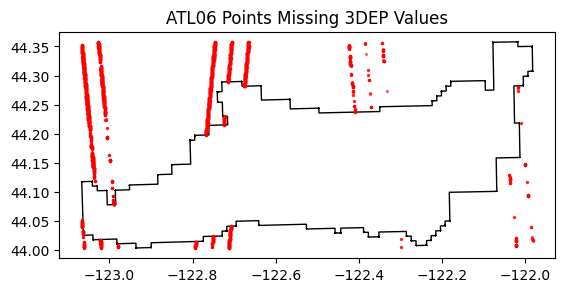

In [19]:
f, ax = plt.subplots()
gf_wesm.plot(ax=ax, facecolor="none", edgecolor='black')
nan_points = gf_atl06_points[gf_atl06_points['3dep.value'].isna()]
nan_points.plot(ax=ax, color='red', markersize=2, alpha=0.5)
plt.title('ATL06 Points Missing 3DEP Values');

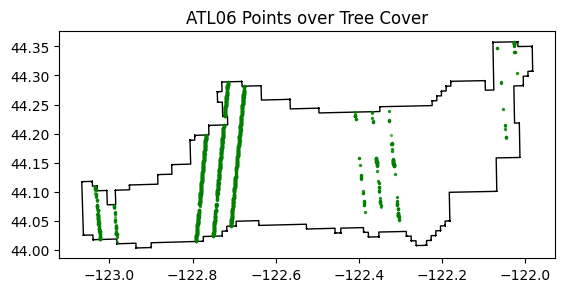

In [20]:
f, ax = plt.subplots()
gf_wesm.plot(ax=ax, facecolor="none", edgecolor='black')
gf_atl06_forest.plot(ax=ax, color='green', markersize=2, alpha=0.5)
plt.title('ATL06 Points over Tree Cover');

In [21]:
gf_atl06_forest["elev_diff"] = gf_atl06_forest["h_mean"] - gf_atl06_forest["3dep.value"]

/home/jehayes/mambaforge/envs/coincident/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


/tmp/ipykernel_50478/2460026017.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


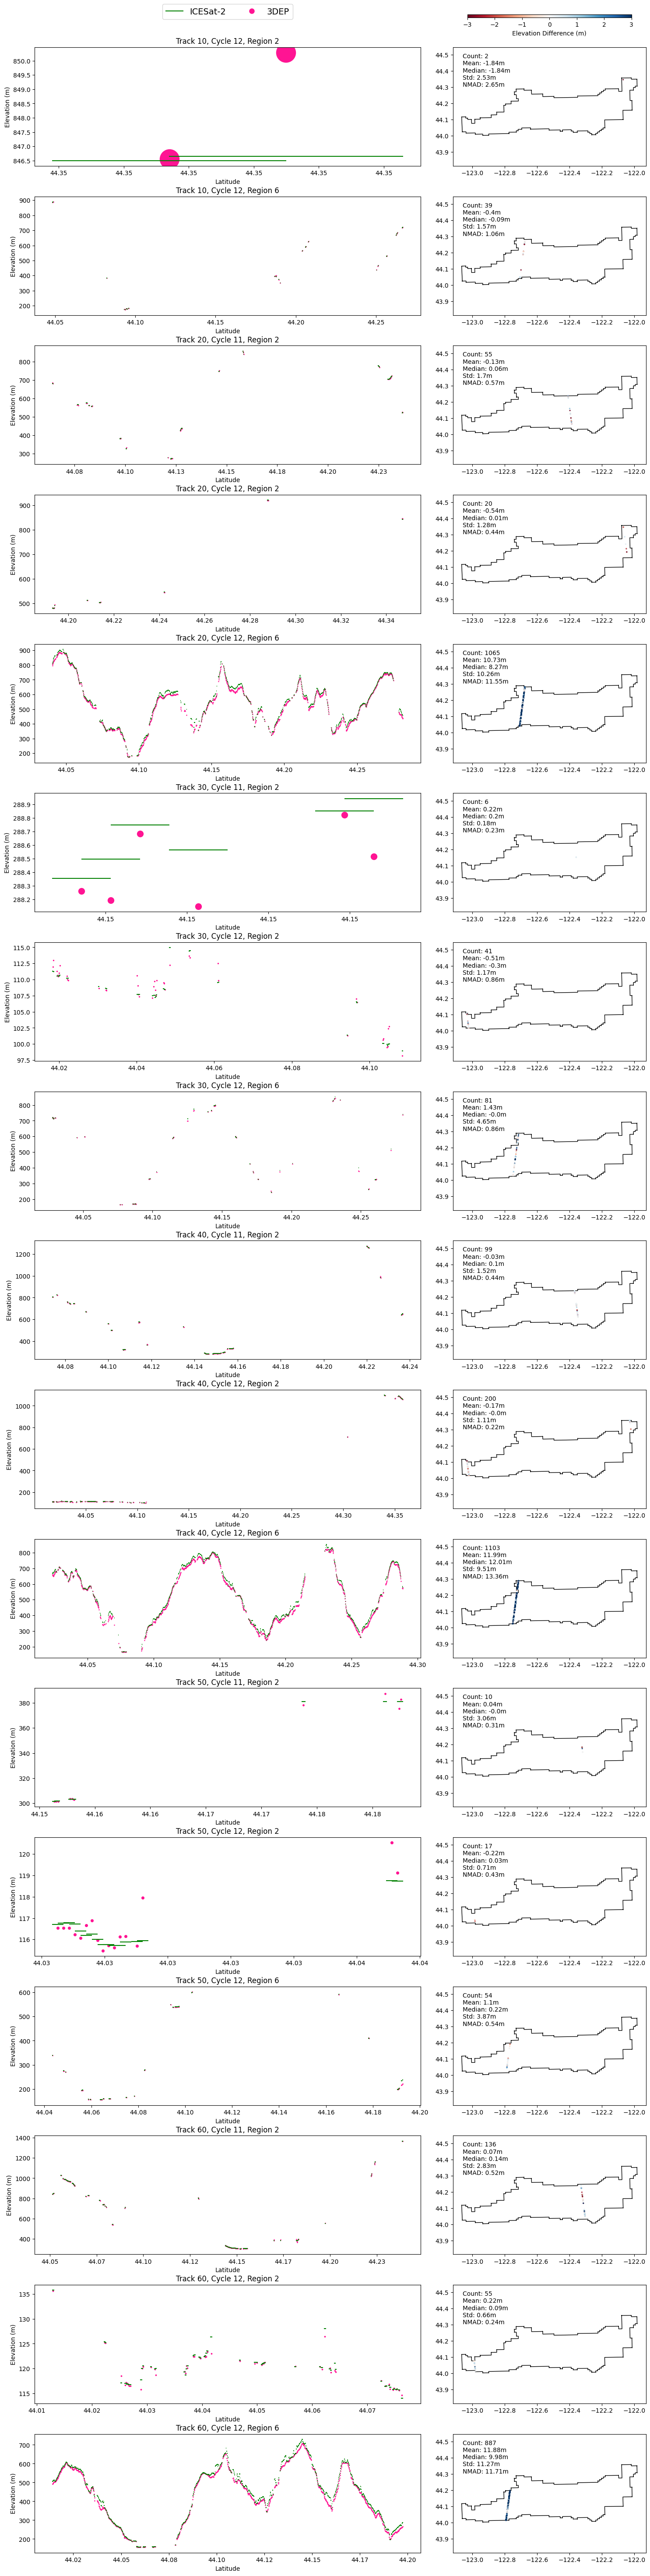

In [22]:
track_groups = gf_atl06_forest.groupby(["gt", "cycle", "region"])
n_groups = len(track_groups)

fig = plt.figure(figsize=(15, 4*n_groups))
gs = GridSpec(n_groups, 2, width_ratios=[2, 1])

# Create a colorbar axis above the right column
cbar_ax = fig.add_axes([.715, 0.86, 0.25, 0.001]) 
norm = plt.Normalize(vmin=-3, vmax=3)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
plt.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Elevation Difference (m)')

for idx, (name, group) in enumerate(track_groups):
    ax1 = fig.add_subplot(gs[idx, 0])
    
    meters_to_degrees_40m = 40 / 111000
    y_coords = [geom.y for geom in group.geometry]
    
    # Create horizontal lines for ICESat-2 elevations
    for lat, elev in zip(y_coords, group['h_mean']):
        ax1.hlines(y=elev, xmin=lat-meters_to_degrees_40m/2, xmax=lat+meters_to_degrees_40m/2,
                  colors='green', label='ICESat-2' if (idx==0 and lat==y_coords[0]) else "")
    
    # Calculate dynamic marker size based on x-axis range
    x_range = max(y_coords) - min(y_coords)
    marker_size = (meters_to_degrees_40m / x_range) * 500
    
    # Plot 3DEP points with dynamic sizing
    ax1.scatter(y_coords, group['3dep.value'],
               marker='o',
               c='deeppink',
               alpha=1.0,
               s=marker_size,
               label='3DEP' if idx==0 else "")
    
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('Elevation (m)')
    ax1.set_title(f'Track {name[0]}, Cycle {name[1]}, Region {name[2]}')
    
    # Format x-axis to show two decimal places
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    # For the legend, we can control marker size specifically for the legend:
    if idx == 0:
        legend_elements = [
            Line2D([0], [0], color='green', label='ICESat-2'),
            Line2D([0], [0], marker='o', color='w', label='3DEP',
                markerfacecolor='deeppink', markersize=10)
        ]
        ax1.legend(handles=legend_elements, bbox_to_anchor=(0.5, 1.3), 
                loc='center', ncol=2, fontsize=14)

    
    # Enhanced map plot with elevation differences
    ax2 = fig.add_subplot(gs[idx, 1])
    gf_wesm.plot(ax=ax2, facecolor="none", edgecolor='black')
    group.plot(ax=ax2, column='elev_diff', cmap='RdBu',
              vmin=-3, vmax=3, alpha=0.7, markersize=2)
    ax2.set_title('')
    mean_diff = round(group['elev_diff'].mean(), 2)
    median_diff = round(group['elev_diff'].median(), 2)
    std_diff = round(group['elev_diff'].std(), 2)
    nmad = round(1.4826 * np.median(np.abs(group['elev_diff'] - median_diff)), 2)
    count = len(group)

    # Add stats text
    stats_text = f'Count: {count}\nMean: {mean_diff}m\nMedian: {median_diff}m\nStd: {std_diff}m\nNMAD: {nmad}m'
    ax2.text(0.05, 0.95, stats_text, 
            transform=ax2.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax2.axis('equal')

plt.tight_layout()
# Adjust layout to accommodate the colorbar and legend
plt.subplots_adjust(top=0.85)

In [23]:
from scipy import stats

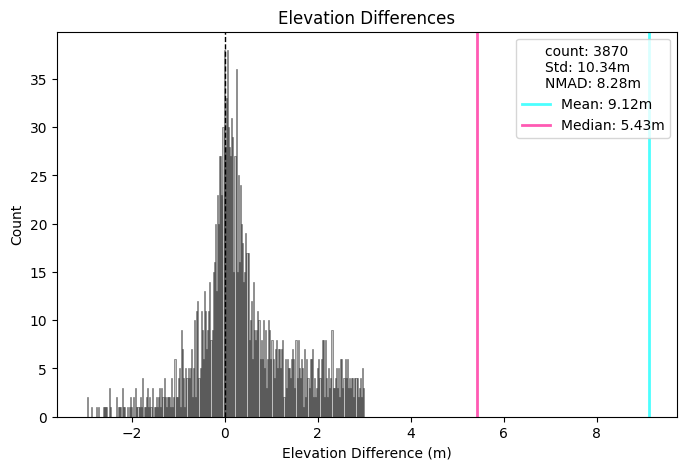

In [24]:
# Extract elevation difference values... cycle 12 region 6 is crazy biased
elev_diff = gf_atl06_forest['elev_diff']
mean_diff = elev_diff.mean()
median_diff = elev_diff.median()
std_diff = elev_diff.std()
nmad = stats.median_abs_deviation(elev_diff, scale="normal")
count = len(elev_diff) 
f, ax = plt.subplots(figsize=(8, 5))
ax.hist(elev_diff, bins=256, range=(-3, 3), color='gray', alpha=0.5, 
        edgecolor='black', linewidth=0.5)
ax.axvline(0, color='black', linestyle='dashed', linewidth=1)  # Center line at x=0
ax.axvline(mean_diff, color='cyan', linestyle='solid', linewidth=2, 
           label=f'Mean: {mean_diff:.2f}m', alpha=0.7)
ax.axvline(median_diff, color='deeppink', linestyle='solid', linewidth=2, 
           label=f'Median: {median_diff:.2f}m', alpha=0.7)
stats_text = f'count: {count}\nStd: {std_diff:.2f}m\nNMAD: {nmad:.2f}m'
ax.legend(title=stats_text, loc='upper right', fontsize=10)
ax.set_xlabel('Elevation Difference (m)')
ax.set_ylabel('Count')
ax.set_title('Elevation Differences');

In [25]:
fn_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/refs/heads/master/data/geojson/us-states.json'
gf_states = gpd.read_file(fn_states)
hi_ak_pr = ["Alaska", "Hawaii", "Puerto Rico"]
gf_conus = gf_states[~gf_states["name"].isin(hi_ak_pr)].to_crs(gf_atl06_forest.crs)

In [26]:
gf_wesm['median_diff'] = median_diff

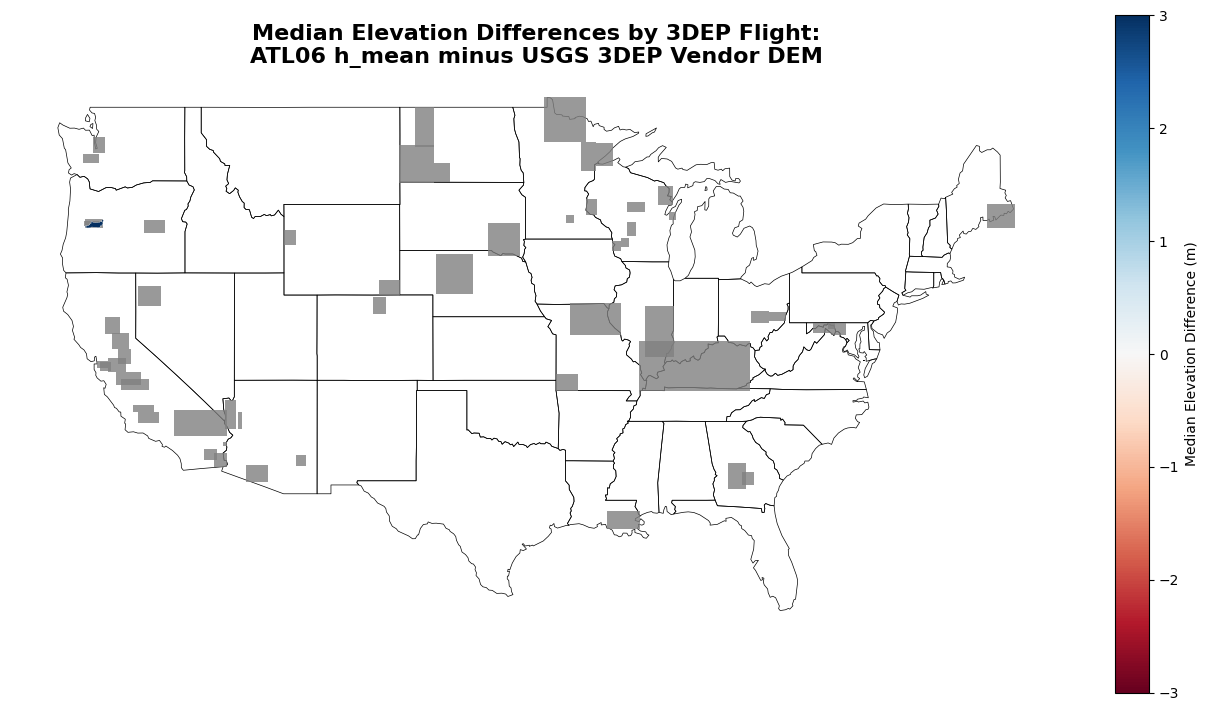

In [27]:
f, ax = plt.subplots(figsize=(12,7), layout='constrained')
gf_conus.to_crs(3857).plot(ax=ax, facecolor='none', 
              edgecolor='black', linewidth=0.5)
gf_flights.to_crs(3857).plot(ax=ax, color='gray', alpha=0.8)
norm = mcolors.Normalize(vmin=-3, vmax=3)
cmap = cm.RdBu
gf_wesm.to_crs(3857).plot(ax=ax, column='median_diff', cmap=cmap, 
             norm=norm, legend=True, edgecolor="white",
             linewidth=0.2, legend_kwds = {"label":"Median Elevation Difference (m)"})
#ctx.add_basemap(ax=ax, crs=gf_conus.crs,
#                source=ctx.providers.Esri.WorldImagery,
#                attribution=False)
ax.set(xticks=[], yticks=[], 
       xlabel="", ylabel="", 
       frame_on=False)
ax.set_aspect('equal')
ax.set_title("Median Elevation Differences by 3DEP Flight:\nATL06 h_mean minus USGS 3DEP Vendor DEM",
             fontsize=16, fontweight='bold');

Now, let's look at custom parameters:

In [28]:
from sliderule import icesat2

#### New custom params

https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html

Below are detailed explanations for the changes made in our custom parameter set:

**srt (Surface Type Selection)**
Set to `-1` to instruct the server-side code to inspect the ATL03 confidence array for each photon and choose the highest confidence level across all five surface type entries.

**cnf (Confidence Threshold)**
Setting this to `4` increases the strictness of the surface photon selection, reducing false positives and creating more distinct differences between custom and standard products.

**ats (Along‐track Spacing)**
Reduced from `10.0 m` to `5.0 m`, which increases the sampling density along the track and helps capture more localized variations in surface height.

**cnt (Photon Count Threshold)**
Increased from `10` to `15` to ensure that even with a shorter segment length, each segment gathers enough signal photons for robust height estimation and to reduce the impact of noise.

**len (Segment Length)**
Decreased from `40.0 m` to `30.0 m` to improve the spatial resolution of the derived heights.

**res (Resolution)**
Set to `10.0 m` (instead of a higher value) to yield even denser sampling and increased overlap between segments. With a segment length of `30.0 m`, a `10.0 m` resolution results in a greater number of overlapping segments, enhancing consistency.

**maxi**
Kept at `5`, which is used internally (e.g., to limit the maximum number of features considered during signal selection).

**atl08_class**
Including `"atl08_top_of_canopy"` and `"atl08_canopy"` directs the processing to retrieve both canopy and top-of-canopy returns, useful for comparing vegetation and ground heights.



In [29]:
# https://github.com/SlideRuleEarth/sliderule/issues/448
custom_atl06_params = {
    "srt": -1,
    "cnf": 4,                          
    "ats": 5.0,                          
    "cnt": 15,                          
    "len": 30.0,                         
    "res": 10.0,                        
    "maxi": 5,
    "atl08_class": ["atl08_top_of_canopy", "atl08_canopy"],
}

In [30]:
gf_atl06_points_custom = misc.sr_wrapper.get_atl06(
    gf_atl06_stac,
    window_start = atl06_items[1],
    window_end = atl06_items[2],
    aoi_geometry= gf_flights.iloc[0].geometry,
    include_3dep=True,
    include_worldcover=True,
    default=False,
    sliderule_params=custom_atl06_params)

In [31]:
print("Defualt ATL06 Processing returned:")
print("Reference Ground Tracks: {}".format(gf_atl06_points["rgt"].unique()))
print("Cycles: {}".format(gf_atl06_points["cycle"].unique()))
print("Received {} elevations".format(gf_atl06_points.shape[0]))
print("\nCustom ATL06 Processing returned:")
print("Reference Ground Tracks: {}".format(gf_atl06_points_custom["rgt"].unique()))
print("Cycles: {}".format(gf_atl06_points_custom["cycle"].unique()))
print("Received {} elevations".format(gf_atl06_points_custom.shape[0]))

Defualt ATL06 Processing returned:
Reference Ground Tracks: [1332    6   44  387]
Cycles: [11 12]
Received 10098 elevations

Custom ATL06 Processing returned:
Reference Ground Tracks: [1332    6   44  387]
Cycles: [11 12]
Received 9408 elevations


In [32]:
gf_atl06_points_custom['3dep.value'] = gf_atl06_points_custom['3dep.value'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
gf_atl06_forest_custom = gf_atl06_points_custom[
    (gf_atl06_points_custom['3dep.value'].notna()) & 
    (gf_atl06_points_custom['worldcover.value'] == 10.0)
]

In [33]:
print("After filtering on forest cover and valid points:\n")
print("Defualt ATL06 Processing returned:")
print("Reference Ground Tracks: {}".format(gf_atl06_forest["rgt"].unique()))
print("Cycles: {}".format(gf_atl06_forest["cycle"].unique()))
print("Received {} elevations".format(gf_atl06_forest.shape[0]))
print("\nCustom ATL06 Processing returned:")
print("Reference Ground Tracks: {}".format(gf_atl06_forest_custom["rgt"].unique()))
print("Cycles: {}".format(gf_atl06_forest_custom["cycle"].unique()))
print("Received {} elevations".format(gf_atl06_forest_custom.shape[0]))

After filtering on forest cover and valid points:

Defualt ATL06 Processing returned:
Reference Ground Tracks: [1332    6   44  387]
Cycles: [11 12]
Received 3870 elevations

Custom ATL06 Processing returned:
Reference Ground Tracks: [1332    6   44  387]
Cycles: [11 12]
Received 5278 elevations


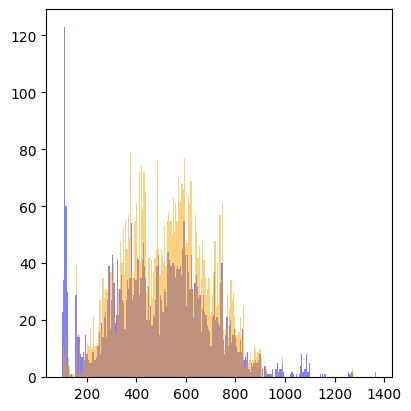

In [34]:
f, ax = plt.subplots(figsize=(4, 4),
                     layout='constrained')
ax.hist(gf_atl06_forest.h_mean, bins=256,
        color='blue', alpha=0.5)
ax.hist(gf_atl06_forest_custom.h_mean, bins=256,
        color='orange', alpha=0.5);

In [35]:
gf_atl06_forest_custom["elev_diff"] = gf_atl06_forest_custom["h_mean"] - gf_atl06_forest_custom["3dep.value"]
print("Defualt ATL06 Processing elevation difference: {}".format(gf_atl06_forest["elev_diff"].median()))
print("Custom ATL06 Processing elevation difference: {}".format(gf_atl06_forest_custom["elev_diff"].median()))

Defualt ATL06 Processing elevation difference: 5.433482278010189
Custom ATL06 Processing elevation difference: 10.416011635124505


/home/jehayes/mambaforge/envs/coincident/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
median_diff_by_cycle = gf_atl06_forest.groupby("cycle")["elev_diff"].median()
# Identify biased cycles where the absolute median height difference is greater than 5
biased_cycles = median_diff_by_cycle[median_diff_by_cycle.abs() > 5].index
# Filter out rows that belong to those biased cycles
gf_atl06_forest_unbiased = gf_atl06_forest[~gf_atl06_forest["cycle"].isin(biased_cycles)]

In [37]:
median_diff_by_cycle = gf_atl06_forest_custom.groupby("cycle")["elev_diff"].median()
# Identify biased cycles where the absolute median height difference is greater than 5
biased_cycles = median_diff_by_cycle[median_diff_by_cycle.abs() > 5].index
# Filter out rows that belong to those biased cycles
gf_atl06_forest_custom_unbiased = gf_atl06_forest_custom[~gf_atl06_forest_custom["cycle"].isin(biased_cycles)]

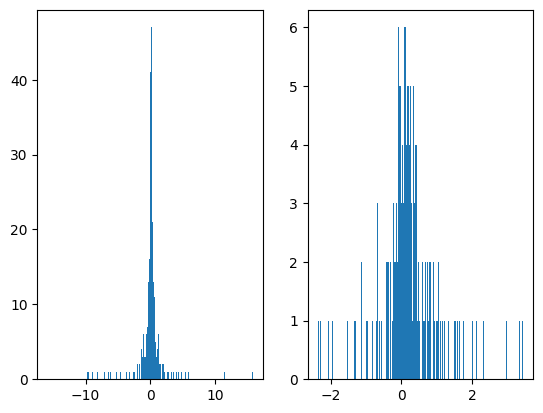

In [38]:
f,ax = plt.subplots(1,2)
ax[0].hist(gf_atl06_forest_unbiased.elev_diff,
         bins=256)
ax[1].hist(gf_atl06_forest_custom_unbiased.elev_diff,
         bins=256);

In [39]:
gf_wesm

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration,median_diff
0,OR_McKenzieRiver_1_2021,220421,OR_McKenzieRiver_2021_B21,220424,2021-07-04,2021-07-06,QL 1,USGS Lidar Base Specification 2.1,linear-mode lidar,0.4572,...,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-122.93477 44.00285, -122.9347...",3DEP,2021-07-05,186,2,5.433482


In [51]:
srt = int(custom_atl06_params['srt'])
cnf = int(custom_atl06_params['cnf'])
ats = int(custom_atl06_params['ats'])
length = int(custom_atl06_params['len'])
res = int(custom_atl06_params['res'])
maxi = int(custom_atl06_params['maxi'])

In [52]:
med_value = (gf_atl06_forest_unbiased.elev_diff.median()*100).round().astype(int)
med_value_custom = (gf_atl06_forest_custom_unbiased.elev_diff.median()*100).round().astype(int)
fn_wesm_default = f"{gf_wesm.iloc[0].workunit}_{len(gf_atl06_forest_unbiased)}_count_{med_value}_med.parquet"
fn_atl06_default = f"{gf_wesm.iloc[0].workunit}_default_{len(gf_atl06_forest_unbiased)}_count_{med_value}_med.parquet"
fn_atl06_custom = f"{gf_wesm.iloc[0].workunit}_custom_{len(gf_atl06_forest_custom_unbiased)}_count_{med_value_custom}_med_{srt}_{cnf}_{ats}_{length}_{res}_{maxi}.parquet"

In [53]:
print(fn_wesm_default)
print(fn_atl06_default)
print(fn_atl06_custom)

OR_McKenzieRiver_1_2021_306_count_10_med.parquet
OR_McKenzieRiver_1_2021_default_306_count_10_med.parquet
OR_McKenzieRiver_1_2021_custom_191_count_18_med_-1_4_5_30_10_5.parquet


In [66]:
gf_flights = gpd.read_file("/home/jehayes/gda_final/ATL06_LaserLottery/test_data/wesm_2021_bboxes_30d_esa.geojson")

In [124]:
for i in range(3,4):
        atl06_items = misc.stac_helper.get_atl06_stac(gf_flights.iloc[i])
        gf_atl06_stac = misc.stac_helper.to_geopandas(atl06_items[0].item_collection())
        gf_atl06_points = misc.sr_wrapper.get_atl06(
            gf_atl06_stac,
            window_start = atl06_items[1],
            window_end = atl06_items[2],
            aoi_geometry= gf_flights.iloc[i].geometry,
            include_3dep=True,
            include_worldcover=True,
        )
        gf_wesm = coincident.search.wesm.load_by_fid(fids=gf_flights.iloc[[i]].fid.values).to_crs(gf_atl06_points.crs)
        # convert any list-like values to floats in '3dep.value'
        try:
            gf_atl06_points['3dep.value'] = gf_atl06_points['3dep.value'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
        except KeyError:
            print(f"Skipping row {i} due to no 3dep samples")
            continue
        # Create forest GDF with valid 3DEP values and forest landcover
        gf_atl06_forest = gf_atl06_points[
            (gf_atl06_points['3dep.value'].notna()) & 
            (gf_atl06_points['worldcover.value'] == 10.0)
        ]
        gf_atl06_forest = gpd.overlay(gf_atl06_forest, 
                                      gf_wesm, 
                                      how='intersection')
        if gf_atl06_forest.empty:
            print(f"Skipping row {i} as no samples after forest filtering")
            continue 
        gf_atl06_forest["elev_diff"] = gf_atl06_forest["h_mean"] - gf_atl06_forest["3dep.value"]

        # remove "bias" cycles
        median_diff_by_cycle = gf_atl06_forest.groupby("cycle")["elev_diff"].median()
        biased_cycles = median_diff_by_cycle[median_diff_by_cycle.abs() > 5].index
        gf_atl06_forest_unbiased = gf_atl06_forest[~gf_atl06_forest["cycle"].isin(biased_cycles)]

        
        elev_diff = gf_atl06_forest_unbiased['elev_diff']
        gf_wesm.at[0, "mean_diff"] = elev_diff.mean()
        gf_wesm.at[0, "med_diff"] = elev_diff.median()
        gf_wesm.at[0, "std_diff"] = elev_diff.std()
        gf_wesm.at[0, "nmad_diff"] = stats.median_abs_deviation(elev_diff, scale="normal")
        gf_wesm.at[0, "n_points"] = len(gf_atl06_forest_unbiased)
        break

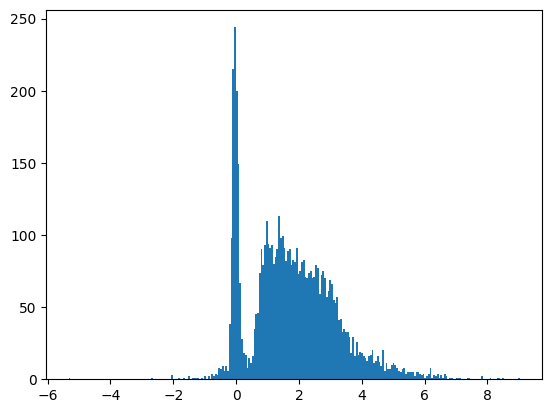

In [125]:
plt.hist(gf_atl06_forest["elev_diff"], bins=256);

In [126]:
median_diff_by_cycle

cycle
11    1.646486
Name: elev_diff, dtype: float64

GT1L = 10 (weak)
GT1R = 20 (strong)
GT2L = 30 (weak)
GT2R = 40 (strong)
GT3L = 50 (weak)
GT3R = 60 (strong)

In [127]:
track_groups = gf_atl06_forest.groupby(["gt", "cycle", "region"])
for idx, (name, group) in enumerate(track_groups):
    print(name, group.elev_diff.median())

(np.uint8(10), np.uint8(11), np.uint8(2)) 1.48491714768881
(np.uint8(10), np.uint8(11), np.uint8(6)) 0.13421605535523184
(np.uint8(20), np.uint8(11), np.uint8(2)) 1.6220764912070518
(np.uint8(20), np.uint8(11), np.uint8(6)) 0.08280671800069328
(np.uint8(30), np.uint8(11), np.uint8(2)) 1.64352579171873
(np.uint8(30), np.uint8(11), np.uint8(6)) -0.0417715775414349
(np.uint8(40), np.uint8(11), np.uint8(2)) 1.7103073228002046
(np.uint8(40), np.uint8(11), np.uint8(6)) 0.047432578818362714
(np.uint8(50), np.uint8(11), np.uint8(2)) 1.9961351130478153
(np.uint8(50), np.uint8(11), np.uint8(6)) -0.13760311331623498
(np.uint8(60), np.uint8(11), np.uint8(2)) 2.4866585253959386
(np.uint8(60), np.uint8(11), np.uint8(6)) 0.017215087909786764


In [129]:
region_groups = gf_atl06_forest.groupby(["region"])

In [131]:
for label, gf in region_groups:
    break

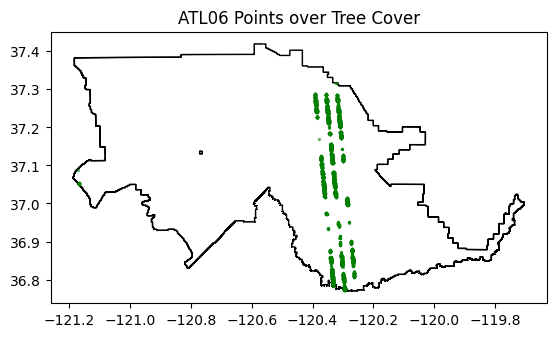

In [132]:
f, ax = plt.subplots()
gf_wesm.plot(ax=ax, facecolor="none", edgecolor='black')
gf.plot(ax=ax, color='green', markersize=2, alpha=0.5)
plt.title('ATL06 Points over Tree Cover');

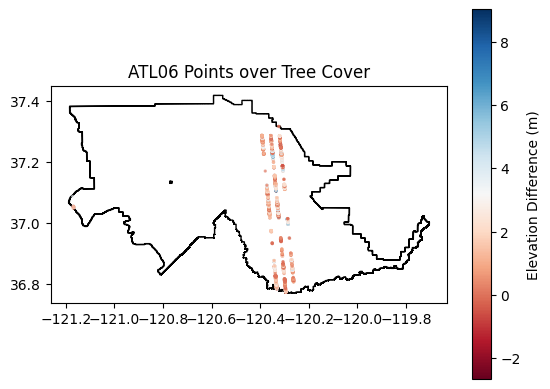

In [134]:
f, ax = plt.subplots()
gf_wesm.plot(ax=ax, facecolor="none", edgecolor='black')
gf.plot(ax=ax, column="elev_diff", markersize=2, alpha=0.5,
        legend=True, legend_kwds={'label': "Elevation Difference (m)"},
        cmap="RdBu")
plt.title('ATL06 Points over Tree Cover');

In [94]:
group.columns

Index(['spot', 'dh_fit_dx', 'rgt', 'h_sigma', 'h_mean', 'rms_misfit',
       'n_fit_photons', 'gt', 'region', 'segment_id', 'pflags', 'x_atc',
       'y_atc', 'cycle', 'w_surface_window_final', 'geometry',
       'worldcover.file_id', 'worldcover.value', 'worldcover.time',
       'worldcover.flags', '3dep.file_id', '3dep.value', '3dep.time',
       '3dep.flags', 'elev_diff'],
      dtype='object')

In [89]:
group.pflags

time
2021-04-19 03:46:15.503143936    0
2021-04-19 03:46:15.505961728    0
2021-04-19 03:46:15.514397440    0
2021-04-19 03:46:15.517202688    0
2021-04-19 03:46:15.520004352    0
                                ..
2021-04-19 03:46:23.723801600    0
2021-04-19 03:46:23.726621696    0
2021-04-19 03:46:23.729443584    0
2021-04-19 03:46:23.732274176    0
2021-04-19 03:46:23.735102720    4
Name: pflags, Length: 734, dtype: uint16

In [85]:
gf_atl06_forest.rgt.unique()

array([387], dtype=uint16)

In [81]:
gf_atl06_forest_unbiased 

,spot,dh_fit_dx,rgt,h_sigma,h_mean,rms_misfit,n_fit_photons,gt,region,segment_id,...,geometry,3dep.file_id,3dep.value,3dep.time,3dep.flags,worldcover.file_id,worldcover.value,worldcover.time,worldcover.flags,elev_diff
time,,,,,,,,,,,,,,,,,,,,,


In [76]:
elev_diff

Series([], Name: elev_diff, dtype: float64)

In [75]:
gf_wesm

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,geometry,collection,datetime,dayofyear,duration,mean_diff,med_diff,std_diff,nmad_diff,n_points
0,WA_KingCo_1_2021,218210,WA_KingCounty_2021_B21,218213,2021-04-01,2021-04-24,QL 1,Other,linear-mode lidar,0.457201,...,"MULTIPOLYGON (((-122.52958 47.3193, -122.52958...",3DEP,2021-04-12 12:00:00,102,23,NaN,NaN,NaN,NaN,0.0
